# WALRUS Sales Analysis and Hypothesis Testing

## Introduction

This Jupyter notebook uses simulated sales data for the WALRUS art gallery. I did not use the real data to preserve the privacy of the artists. Artist names have been replaced with identification numbers. The simulated values are close approximations to the real sales trends I experienced while operating this gallery.

This notebook is designed for potential employers to assess my proficiency in data exploration, visualization, and hypothesis testing.

## Section 1: Data Exploration and Cleaning
**Objective:** Prepare the data for manipulations and get a basic feel for the information contained

### 1.1 Importing Libraries and Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

# Set the style for visualizations
sns.set(style="whitegrid")

In [2]:
# Load the 'WALRUS_soldinventory.csv' dataset
file_path = 'WALRUS_soldinventory.csv'
df = pd.read_csv(file_path)

### 1.2 Preliminary Data Examination and Cleaning

In [3]:
# Display basic statistics
print("Number of rows and columns:", df.shape)
print("\nData types and missing values:")
print(df.info())

Number of rows and columns: (2721, 5)

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2721 entries, 0 to 2720
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date_Sold    2721 non-null   object 
 1   Artist       2718 non-null   float64
 2   Price        2721 non-null   int64  
 3   Intake_Date  2721 non-null   object 
 4   ArtworkId    2716 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 106.4+ KB
None


In [4]:
# Convert 'Date_Sold' and 'Intake_Date' to datetime format
df['Date_Sold'] = pd.to_datetime(df['Date_Sold'])
df['Intake_Date'] = pd.to_datetime(df['Intake_Date'])

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 Date_Sold      0
Artist         3
Price          0
Intake_Date    0
ArtworkId      5
dtype: int64


In [6]:
# Explore ArtowkrId column
print('ArtworkId:', df.ArtworkId.describe(), df.ArtworkId.head())

# Explore Artist column
print('Artist:', df.Artist.describe(), df.Artist.head())

ArtworkId: count          2716
unique         2692
top       43-000038
freq              3
Name: ArtworkId, dtype: object 0    46-555481
1     5-000906
2    45-444074
3    46-111811
4    35-111602
Name: ArtworkId, dtype: object
Artist: count    2718.000000
mean       28.713392
std        14.402282
min         2.000000
25%        17.000000
50%        33.000000
75%        41.000000
max        52.000000
Name: Artist, dtype: float64 0    46.0
1     5.0
2    45.0
3    46.0
4    35.0
Name: Artist, dtype: float64


#### Key Observations
- Date Sold and Intake Date have been changed to datetime formats.
- We can see that there are 5 null values in ArtworkId and that all other values are unique. It looks we can use this column to predict the values that should be artist.

*The following cell uses the ArtowrkId column to fill the null values in artist and then drops the ArtworkId column.*

In [7]:
# Split the 'ArtworkId' values at the '-' and expand them into separate columns
split_artwork_id = df['ArtworkId'].str.split('-', expand=True)

# Assign the values before the '-' to the 'Artist' column where 'Artist' is null
df['Artist'].fillna(split_artwork_id[0], inplace=True)

# Drop the ArtworkId column since all values are unique and it will not be needed for our current goals
df.drop('ArtworkId', axis=1, inplace=True)

# Check all null values have been dealt with
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 Date_Sold      0
Artist         0
Price          0
Intake_Date    0
dtype: int64


### 1.3 Exploratory Data Analysis (EDA)

In [8]:
# Summary statistics
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
              Price
count  2721.000000
mean    211.658949
std     379.782727
min       8.000000
25%      90.000000
50%     140.000000
75%     220.000000
max    6625.000000


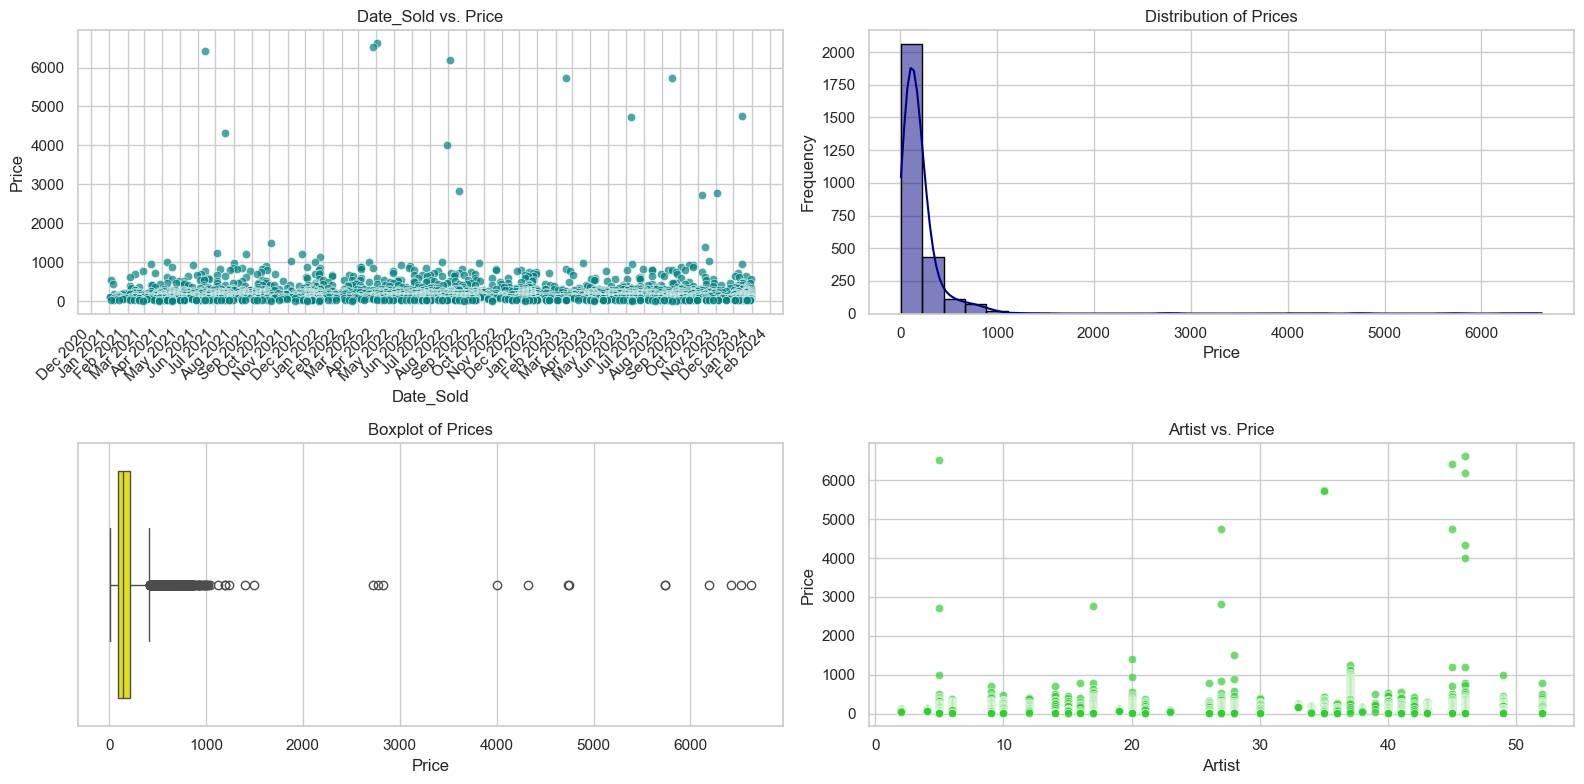

In [9]:
# Visualize distribution of key variables
plt.figure(figsize=(16, 8))

# Convert 'Date_Sold' to datetime format
df['Date_Sold'] = pd.to_datetime(df['Date_Sold'])

# Date_Sold vs. Price (Sampling for better visualization)
plt.subplot(2, 2, 1)
sns.scatterplot(x='Date_Sold', y='Price', data=df, color='teal', alpha=0.7)
plt.title('Date_Sold vs. Price')
plt.xlabel('Date_Sold')
plt.ylabel('Price')

# Improve x-axis labels by grouping dates by month and year
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major locator to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as abbreviated month and year
# Distribution of Prices
plt.subplot(2, 2, 2)
sns.histplot(df['Price'], bins=30, kde=True, color='navy', edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Boxplot of Prices
plt.subplot(2, 2, 3)
sns.boxplot(x=df['Price'], color='yellow')
plt.title('Boxplot of Prices')
plt.xlabel('Price')

# Artist vs. Price
plt.subplot(2, 2, 4)
sns.scatterplot(x='Artist', y='Price', data=df, color='limegreen', alpha=0.7)
plt.title('Artist vs. Price')
plt.xlabel('Artist')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

#### Key Observations

The following code visualizes key variables in the dataset to provide insights into the distribution of prices and potential correlations. Let's break down the results:

###### Date\_Sold vs. Price
- **Insight:** No discernible correlation between the date of sale and artwork prices.
- **Visualization:** Scatter plot.

###### Distribution of Prices
- **Insight:** Peak in the smallest price range, with a steady decline as prices increase, particularly after \$1000.
- **Visualization:** Histogram.

###### Boxplot of Prices
- **Insight:** Presence of significant outliers on the high end, majority falling just above the top whisker, especially those exceeding \$6000.
- **Visualization:** Boxplot.

###### Artist vs. Price
- **Insight:** Only six artists sold artworks priced over \\\$2000, with most focusing on pieces under \\\$1000.
- **Visualization:** Scatter plot.

These visualizations offer valuable insights into the dataset's price distribution, potential outliers, and the pricing strategies of different artists.

## Section 2: Exploring Sales Patterns and Artist Performance
**Objectives:** 
- Investigate sales patterns over time and identify any trends or seasonality.
- Evaluate the performance of individual artists in terms of total sales and average prices.
### 2.1 Sales Patterns Over Time

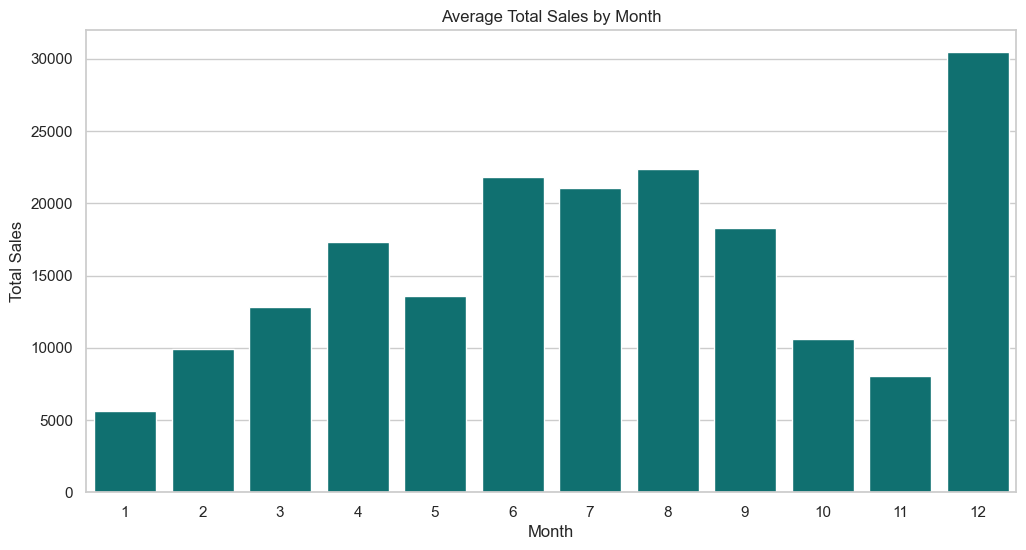

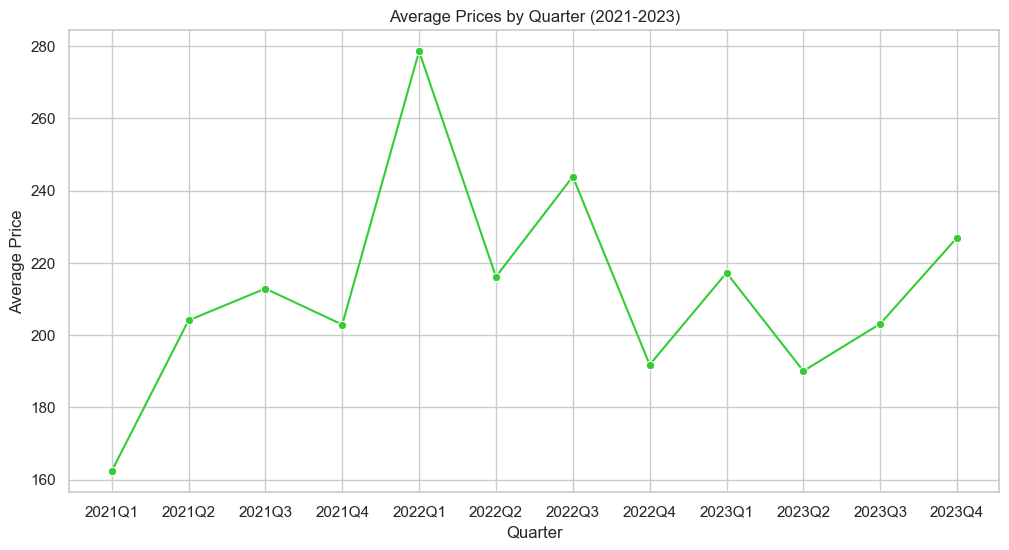

In [10]:
# Extract month and quarter information
df['Month'] = df['Date_Sold'].dt.month
df['Quarter'] = df['Date_Sold'].dt.to_period("Q")

# Total Sales Over Months
plt.figure(figsize=(12, 6))
sales_over_months = df.groupby('Month')['Price'].sum() / 3 #for the number of years in the dataset
sns.barplot(x=sales_over_months.index, y=sales_over_months, color='teal')
plt.title('Average Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

# Average Prices Over Quarters
plt.figure(figsize=(12, 6))
avg_prices_over_quarters = df.groupby('Quarter')['Price'].mean()
sns.lineplot(x=avg_prices_over_quarters.index.astype(str), y=avg_prices_over_quarters, marker='o', color='limegreen')
plt.title('Average Prices by Quarter (2021-2023)')
plt.xlabel('Quarter')
plt.ylabel('Average Price')
plt.show()

#### Key Observations

The provided code extracts valuable insights from the dataset by transforming the 'Date_Sold' column into a datetime format and subsequently extracting month and quarter information. The resulting visualizations highlight key trends:

##### Total Sales Over Months
- **Insight:** A discernible pattern emerges, with sales starting below 2000 in January, steadily climbing to a peak in June with sales over 6000. There's a slight dip in July, but sales remain above 6000, followed by an increase in August. A consistent decline is observed from September to November, with November being the second-lowest, surpassed only by January. December stands out as the highest, exceeding 9000.
- **Visualization:** Bar chart.

##### Average Prices Over Quarters
- **Insight:** The trend in average prices over quarters aligns with the total sales pattern. The spike in 2022Q1 is noteworthy, indicating a significant increase in average prices during that period.
- **Visualization:** Line plot with markers.

These visualizations provide a comprehensive overview of sales trends, emphasizing the seasonality of sales and fluctuations in average prices over different quarters. The distinct patterns observed in both graphs offer actionable insights for strategic decision-making in inventory management and pricing strategies.


### 2.2 Artist Performance

In [11]:
df['Artist'] = df['Artist'].astype(int)
# Get unique artists in the dataset
unique_artists = df['Artist'].unique()

# Create a color mapping for each artist
artist_color_mapping = {artist: sns.color_palette('viridis', n_colors=len(unique_artists))[i] for i, artist in enumerate(unique_artists)}

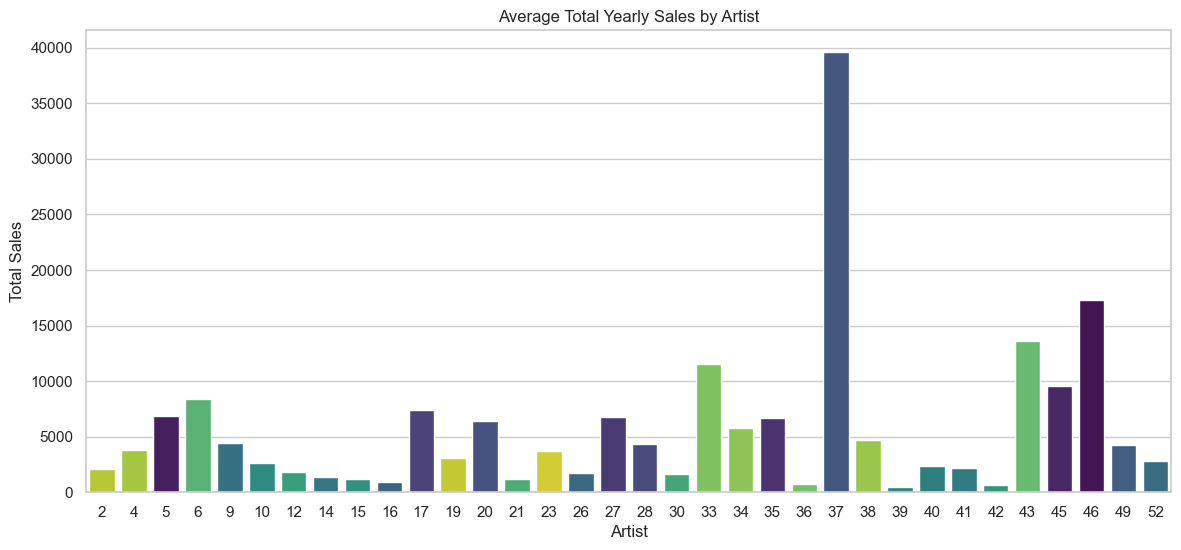

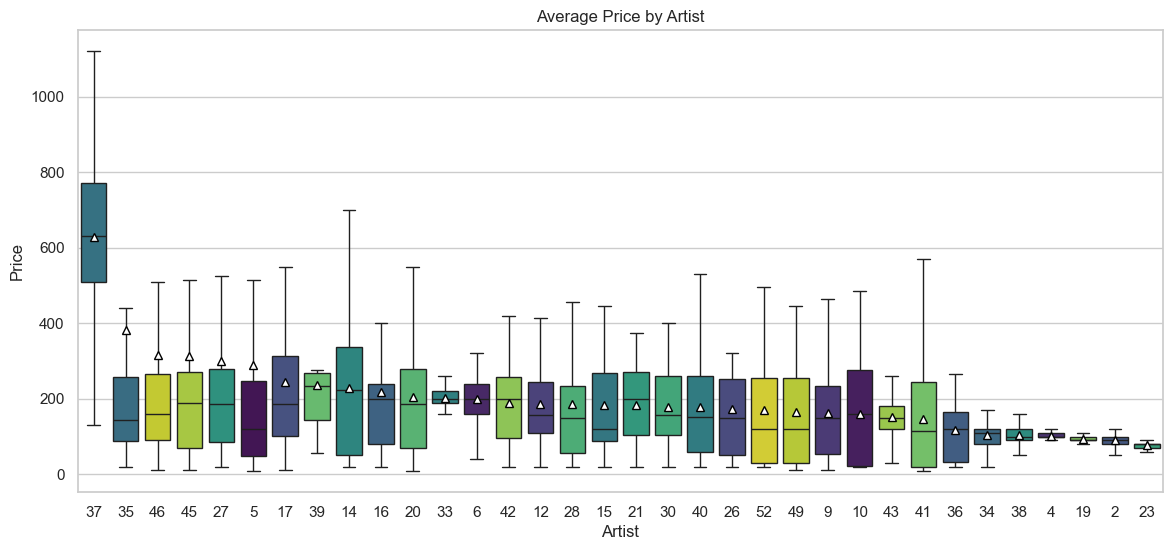

In [12]:
# Total Sales by Artist
plt.figure(figsize=(14, 6))
total_sales_by_artist = df.groupby('Artist')['Price'].sum().sort_values(ascending=False) / 3 #for the 3 years in the dataset
sns.barplot(x=total_sales_by_artist.index, y=total_sales_by_artist, hue=total_sales_by_artist.index, palette=[artist_color_mapping[artist] for artist in total_sales_by_artist.index], hue_order=total_sales_by_artist.index, legend=False)
plt.title('Average Total Yearly Sales by Artist')
plt.xlabel('Artist')
plt.ylabel('Total Sales')
plt.show()

# Average Price by Artist
plt.figure(figsize=(14, 6))
avg_prices_by_artist = df.groupby('Artist')['Price'].mean().sort_values(ascending=False)
sns.boxplot(x=df['Artist'], y=df['Price'], order=avg_prices_by_artist.index, hue=df['Artist'], palette=[artist_color_mapping[artist] for artist in avg_prices_by_artist.index], showfliers=False, showmeans=True, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, legend=False)
plt.title('Average Price by Artist')
plt.xlabel('Artist')
plt.ylabel('Price')
plt.show()

#### Key Observations
##### Total Sales by Artist
- **Insight:** Artist 37 emerges as the top performer, boasting total sales nearing \\\$40,000, significantly surpassing other artists. Artist 46 follows as the next highest with sales just over \\\$15,000.
- **Visualization:** Bar chart with each artist's distinctive color.

##### Average Price by Artist
- **Insight:** Artist 37 stands out not only for the highest total sales but also for one of the largest price ranges, with the inner quartile surpassing the top whisker of most other artists. Artist 14 also exhibits a notable price range, while Artist 39's inner quartile near the top of their range suggests a focus on higher-priced artworks.
- **Visualization:** Boxplot with distinctive colors for each artist, highlighting their price distribution.

These visualizations offer a comprehensive understanding of individual artist contributions, emphasizing top performers and nuances in pricing strategies. This information is crucial for tailored inventory management and strategic decisions in optimizing sales based on artists' performance and pricing dynamics.


## Section 3: Revenue and Sales Analysis
**Objectives:** Check for effects on sales from time, artists, and price.
### 3.1 Total Revenue Over Time

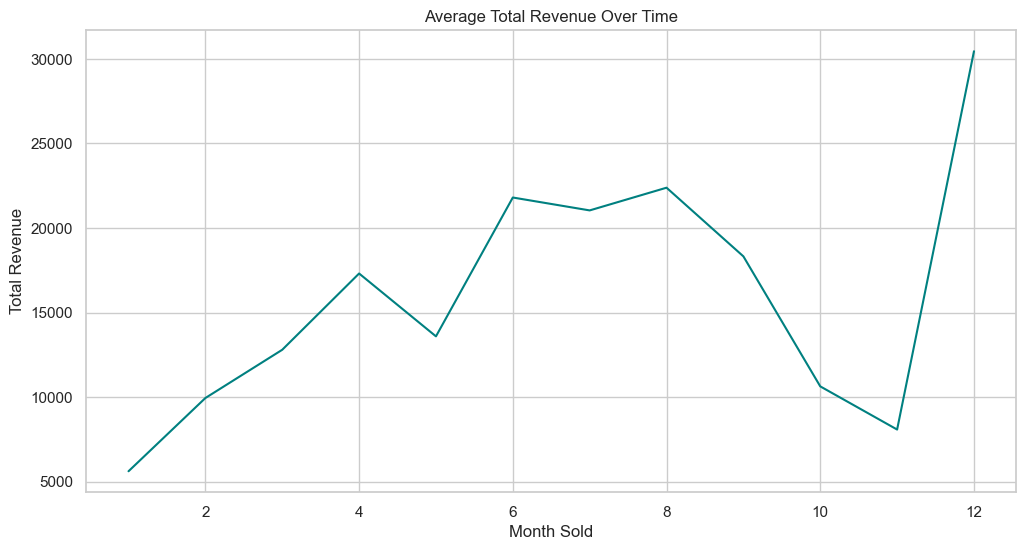

In [13]:
#Visualize the total revenue trend over the entire dataset
plt.figure(figsize=(12, 6))
total_revenue_over_time = df.groupby('Month')['Price'].sum() / 3 #for the 3 yrs found in the dataset
total_revenue_over_time.plot(color='teal')
plt.title('Average Total Revenue Over Time')
plt.xlabel('Month Sold')
plt.ylabel('Total Revenue')
plt.show()

#### Key Obeservations
- There are seasonal trends visible

### 3.2 Artist Contribution to Revenue

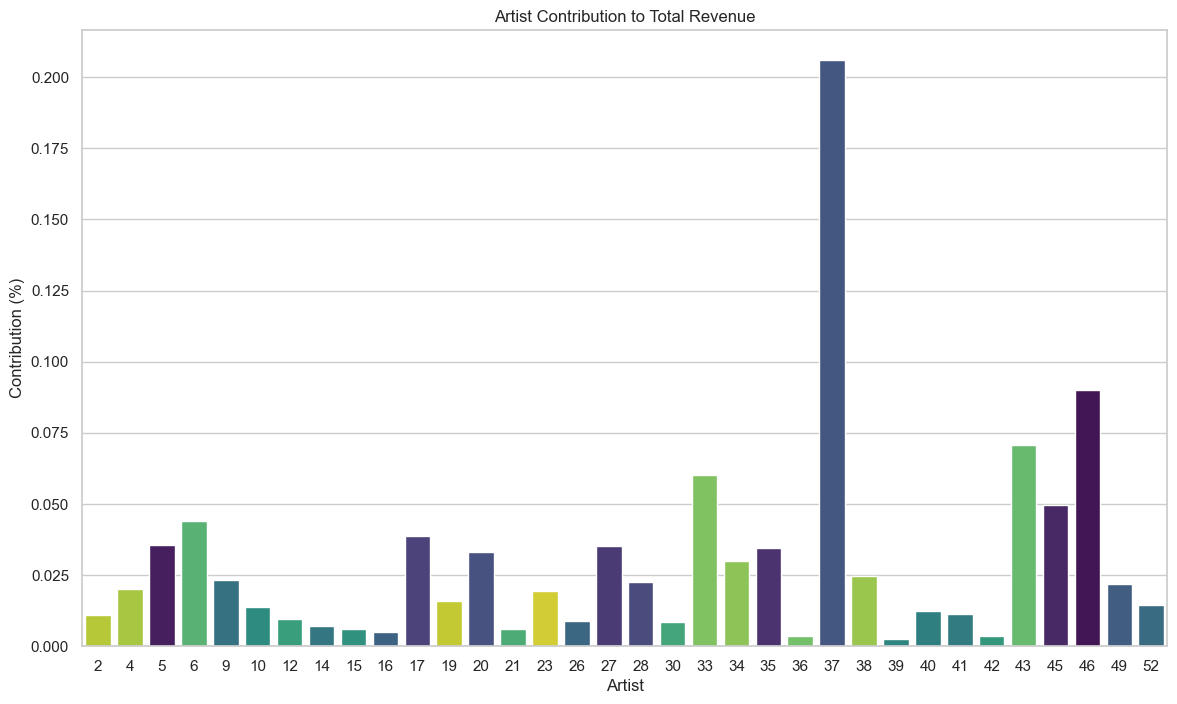

In [14]:
# Analyze the contribution of each artist to the total revenue
plt.figure(figsize=(14, 8))
artist_contribution = df.groupby('Artist')['Price'].sum() / df['Price'].sum()
sns.barplot(x=artist_contribution.index, y=artist_contribution, hue=artist_contribution.index, palette=[artist_color_mapping[artist] for artist in artist_contribution.index], hue_order=artist_contribution.index, legend=False)
plt.title('Artist Contribution to Total Revenue')
plt.xlabel('Artist')
plt.ylabel('Contribution (%)')
plt.show()


#### Key Observations
- Artist contributions vary significantly, with some artists having a notable impact on total revenue.
- Artists 37, 43, and 46 stand out as major contributors, each accounting for a substantial percentage of the total revenue.
- Several artists make relatively smaller contributions, highlighting diversity in the revenue distribution.

### 3.3 Average Price Analysis

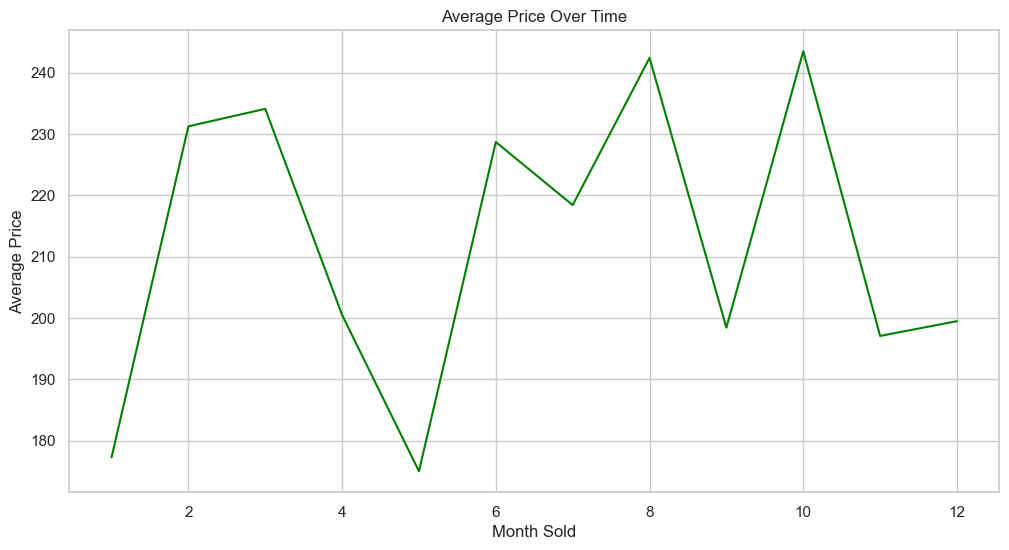

In [15]:
# Explore the average price trend over time
plt.figure(figsize=(12, 6))
average_price_over_time = df.groupby('Month')['Price'].mean()
average_price_over_time.plot(color='green')
plt.title('Average Price Over Time')
plt.xlabel('Month Sold')
plt.ylabel('Average Price')
plt.show()

#### Key Observations
##### Monthly Variability:
- Prices exhibit considerable variability from month to month, indicating potential seasonal trends or market influences.
##### Average Price Insights:
- The average price over the entire dataset is $211.66.
Months with notably higher average prices (e.g., February, March, and October) could be explored to understand the factors contributing to these peaks.

## Section 4: Artist Performance Evaluation
**Objective:** Examine individual artists effects on revenue and isolate top performing artists.
### 4.1 Revenue and Sales Analysis by Artist

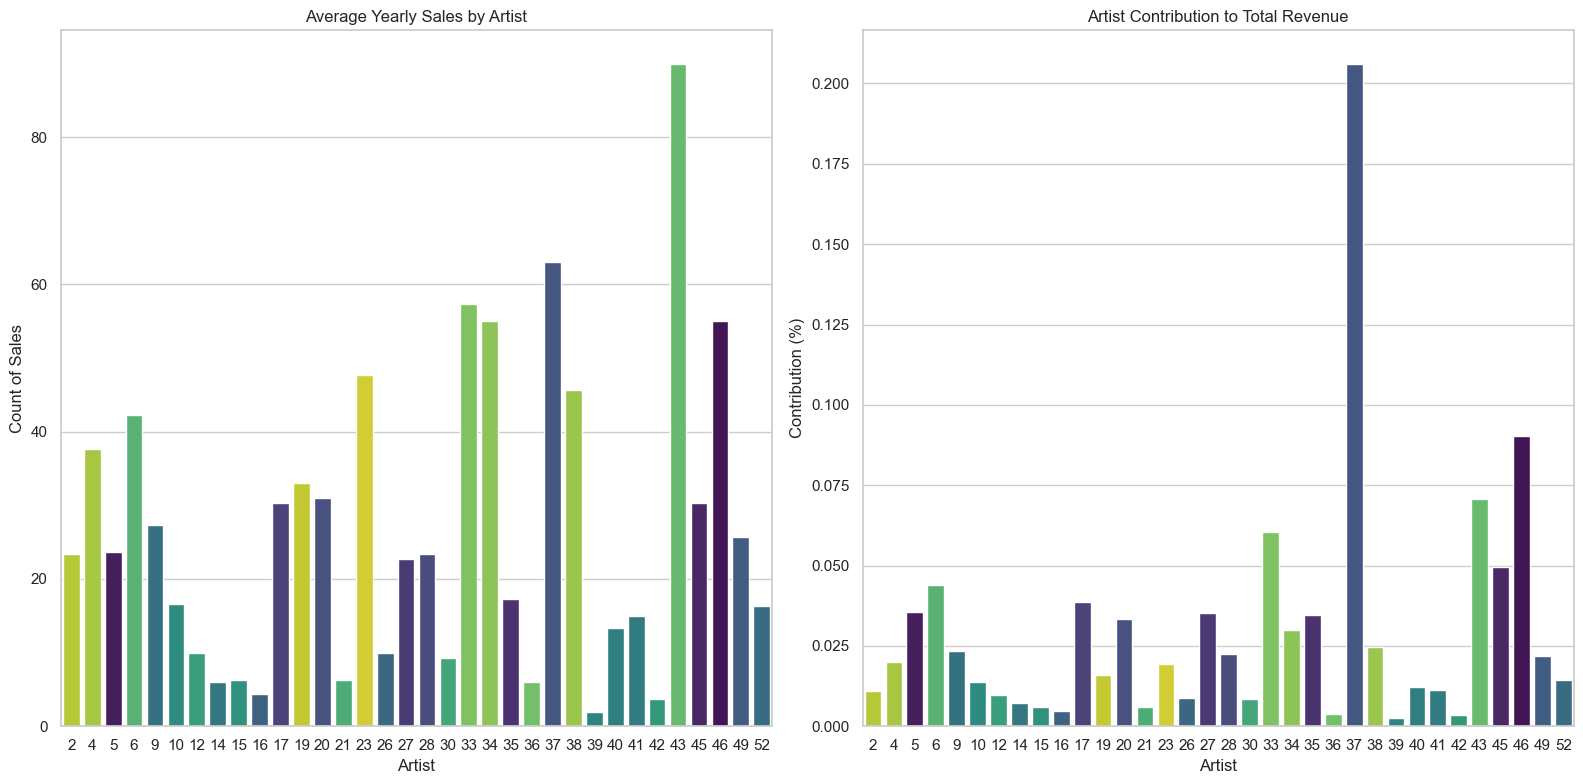

In [16]:
# Visualize the average price and contribution to total revenue by each artist
plt.figure(figsize=(16, 8))

# Bar plot for average price by artist
plt.subplot(1, 2, 1)
avg_sales_by_artist = df.groupby('Artist')['Price'].count().sort_values(ascending=False) / 3 #the number of years in the dataset
sns.barplot(x=avg_sales_by_artist.index, y=avg_sales_by_artist, hue=avg_sales_by_artist.index, palette=[artist_color_mapping[artist] for artist in avg_sales_by_artist.index], hue_order=avg_sales_by_artist.index, legend=False)
plt.title('Average Yearly Sales by Artist')
plt.xlabel('Artist')
plt.ylabel('Count of Sales')

# Bar plot for contribution to total revenue by artist
plt.subplot(1, 2, 2)
sns.barplot(x=artist_contribution.index, y=artist_contribution, hue=artist_contribution.index, palette=[artist_color_mapping[artist] for artist in artist_contribution.index], hue_order=artist_contribution.index, legend=False)
plt.title('Artist Contribution to Total Revenue')
plt.xlabel('Artist')
plt.ylabel('Contribution (%)')

plt.tight_layout()
plt.show()

### 4.2 Identify Top-Performing Artists

In [17]:
# Sort artist_contribution in descending order and get the top 10 contributors
top_artists = artist_contribution.sort_values(ascending=False).head(10)

# Display the result
print("Top-Performing Artists:")
print(top_artists)

Top-Performing Artists:
Artist
37    0.206208
46    0.090203
43    0.070652
33    0.060338
45    0.049590
6     0.043912
17    0.038663
5     0.035640
27    0.035378
35    0.034571
Name: Price, dtype: float64


## Section 5: Days on Market Analysis
**Objective:** Examine the trends for days on market in regards to time, artists, and price.

### 5.1 Days on Market Distribuion:

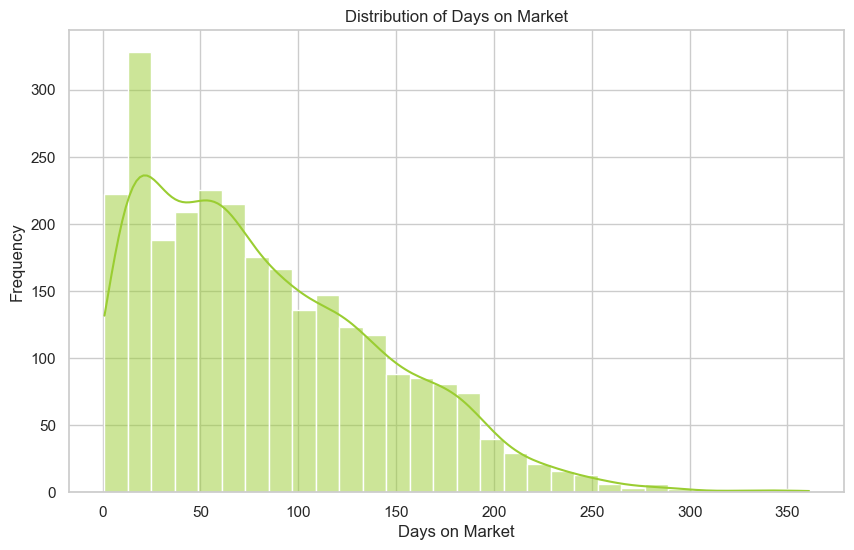

In [18]:
# Calculate Days_on_Market by taking the difference between Date_Sold and Intake_Date
df['Days_on_Market'] = (df['Date_Sold'] - df['Intake_Date']).dt.days

# Visualizing the distribution of Days_on_Market
plt.figure(figsize=(10, 6))
sns.histplot(df['Days_on_Market'], bins=30, kde=True, color='yellowgreen')
plt.title('Distribution of Days on Market')
plt.xlabel('Days on Market')
plt.ylabel('Frequency')
plt.show()

#### Key Observations
- The histogram has a right-skewed distribution, as there is a wider range of values on the higher end, indicating that some artworks take longer to sell.
- The majority of artworks cluster towards the lower end of the scale, with a peak around 20-25 and a tail extending to the right.

### 5.2 Days on Market by Artist

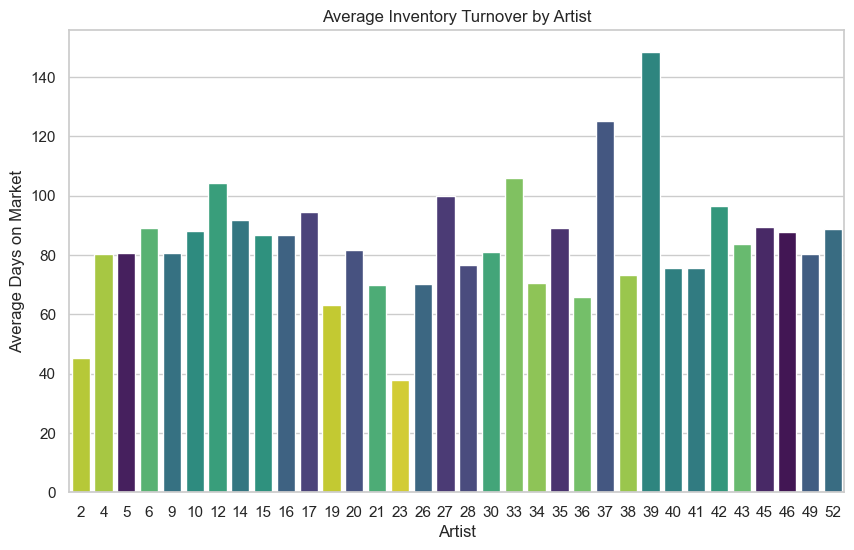

In [19]:
# Calculate and visualize inventory turnover for the top-performing artists
inventory_turnover = df.groupby('Artist')['Days_on_Market'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=inventory_turnover.index, y=inventory_turnover, palette=[artist_color_mapping[artist] for artist in inventory_turnover.index], hue=inventory_turnover.index)
plt.title('Average Inventory Turnover by Artist')
plt.xlabel('Artist')
plt.ylabel('Average Days on Market')
plt.legend().set_visible(False)  # Hide legend
plt.show()

#### Key Observations
##### Shorter Days on Market: 
Artists with a lower average number of days on the market, such as Artist 2, demonstrate quicker inventory turnover. This may indicate a higher demand for their artworks or effective pricing strategies.
##### Longer Days on Market: 
Artists with a higher average number of days on the market, like Artist 39, may have a slower inventory turnover. This could be influenced by factors such as niche markets or specific art styles that require more time to find the right buyers.

### 5.3 Days on Market by Price Range

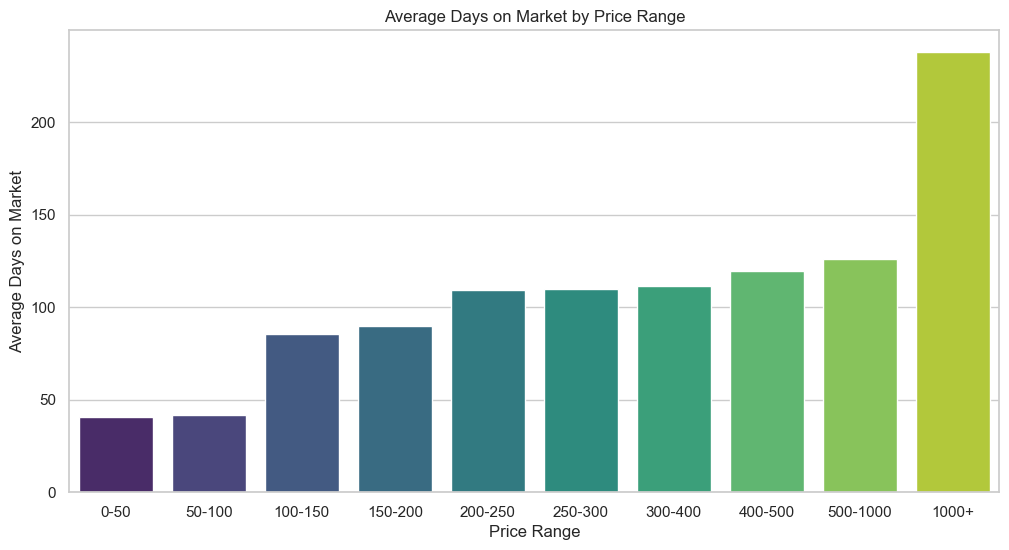

In [20]:
# Define custom price bins based on the data distribution
price_bins = [0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, np.inf]
price_labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-400', '400-500', '500-1000', '1000+']
df['Price_Range'] = pd.cut(df['Price'], bins=price_bins, labels=price_labels, right=False)

# Calculate average Days_on_Market by the updated price range
price_range = df.groupby('Price_Range')['Days_on_Market'].mean().sort_values()

# Bar plot for Average Days on Market by the updated Price Range
plt.figure(figsize=(12, 6))
sns.barplot(x=price_range.index, y=price_range, palette='viridis', hue=price_range.index)
plt.title('Average Days on Market by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Average Days on Market')
plt.show()

#### Key Obeservations
- As Price increases, days on market increases
- Further correlation analysis would be beneficial

## Section 6: Correlation Analysis
**Objective:** Compare observed trends to check for correlations.
### 6.1 Correlation between Price and Days on Market

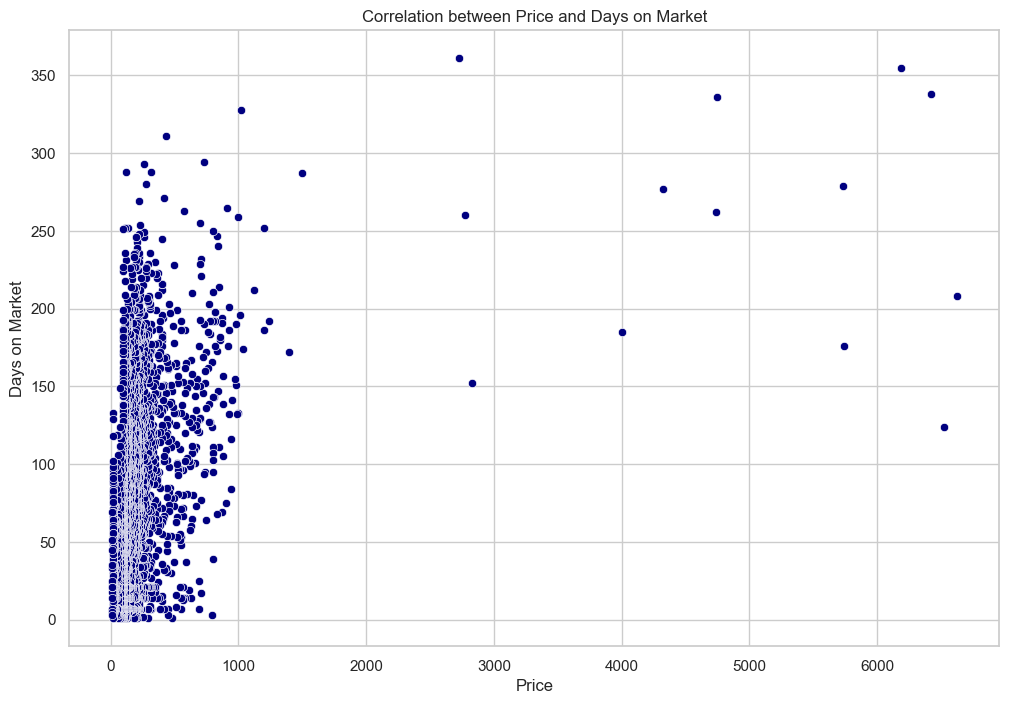

In [21]:
# Scatter plot to visualize the relationship between Price and Days_on_Market
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Days_on_Market', data=df, color='navy')
plt.title('Correlation between Price and Days on Market')
plt.xlabel('Price')
plt.ylabel('Days on Market')
plt.show()

#### Key Observations
- Some correlation seems visible.
- A second graph filtering outliers could give a better view

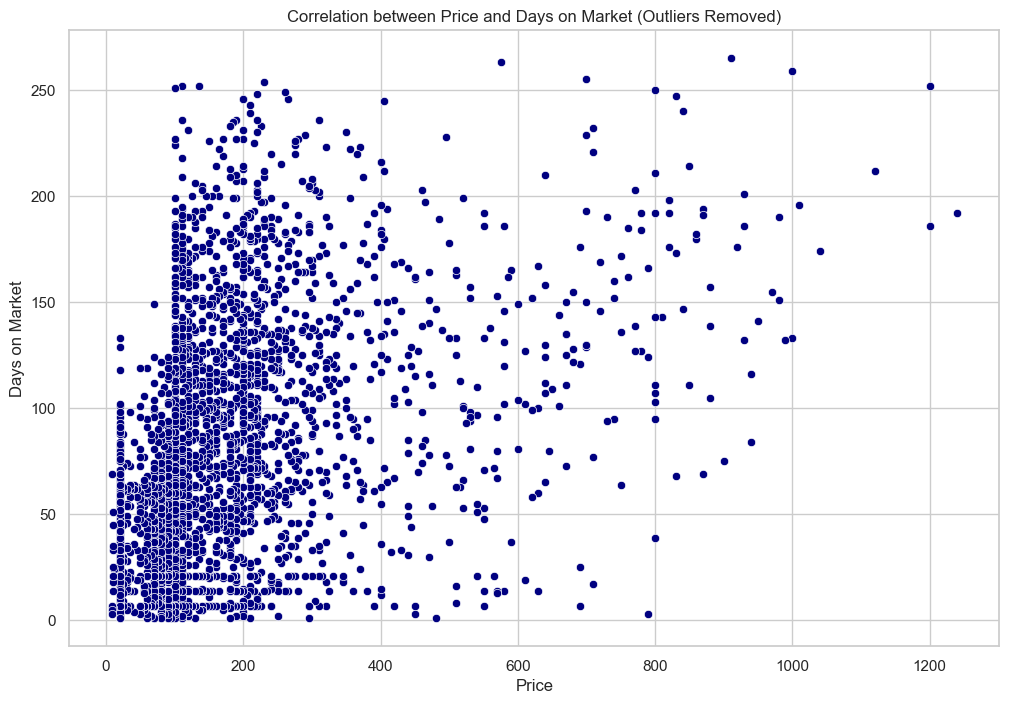

In [22]:
# Remove outliers from 'Price' and 'Days_on_Market'
filtered_df_pd = df[(np.abs(stats.zscore(df['Price'])) < 3) & (np.abs(stats.zscore(df['Days_on_Market'])) < 3)]

# Scatter plot to visualize the relationship between Price and Days_on_Market without outliers
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Days_on_Market', data=filtered_df_pd, color='navy')
plt.title('Correlation between Price and Days on Market (Outliers Removed)')
plt.xlabel('Price')
plt.ylabel('Days on Market')
plt.show()

#### Key Observations
- A positive correlation is noted. Further analysis could be beneficial

### 6.2 Correlation between Artist Contribution and Price

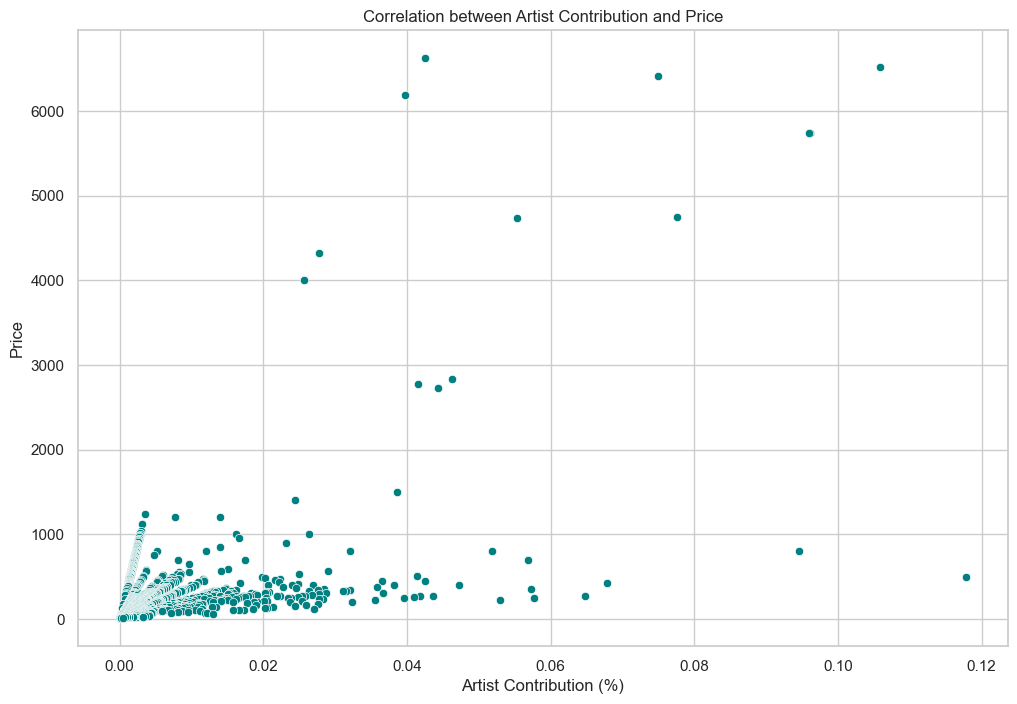

In [23]:
# Calculate Artist Contribution as a percentage of the Total Revenue
df['Artist_Contribution'] = (df['Price'] / df.groupby('Artist')['Price'].transform('sum')) / 3 #for years in dataset

# Scatter plot to visualize the relationship between Artist Contribution and Price
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Artist_Contribution', y='Price', data=df, color='teal')
plt.title('Correlation between Artist Contribution and Price')
plt.xlabel('Artist Contribution (%)')
plt.ylabel('Price')
plt.show()

#### Key Observations
- A positive correlation is visible
- It would be beneficial to filter for outliers

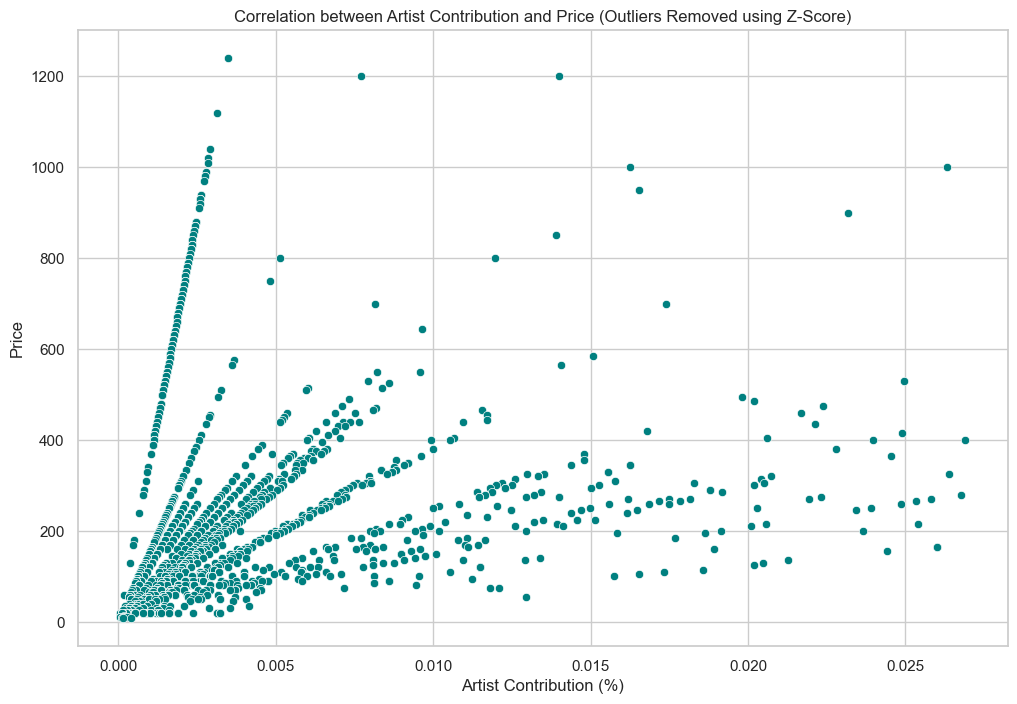

In [24]:
# Filter the DataFrame to exclude outliers based on the z-score for 'Price' and 'Artist_Contribution'
filtered_df_pa = df[(np.abs(stats.zscore(df['Price'])) < 3) & (np.abs(stats.zscore(df['Artist_Contribution'])) < 3)]

# Scatter plot without outliers
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Artist_Contribution', y='Price', data=filtered_df_pa, color='teal')
plt.title('Correlation between Artist Contribution and Price (Outliers Removed using Z-Score)')
plt.xlabel('Artist Contribution (%)')
plt.ylabel('Price')
plt.show()

#### Key Observations
- The clustering near the origin suggests that a considerable portion of artworks has a lower Artist Contribution and correspondingly lower Prices.
- The spreading arms of the "V" indicate variability in Price for higher Artist Contributions, suggesting diverse pricing strategies among artists.
- The positive correlation implies that artists with a higher contribution tend to have artworks with higher prices, although the relationship is not perfectly linear.

### 6.3 Correlation between Days on Market and Artist Contribution

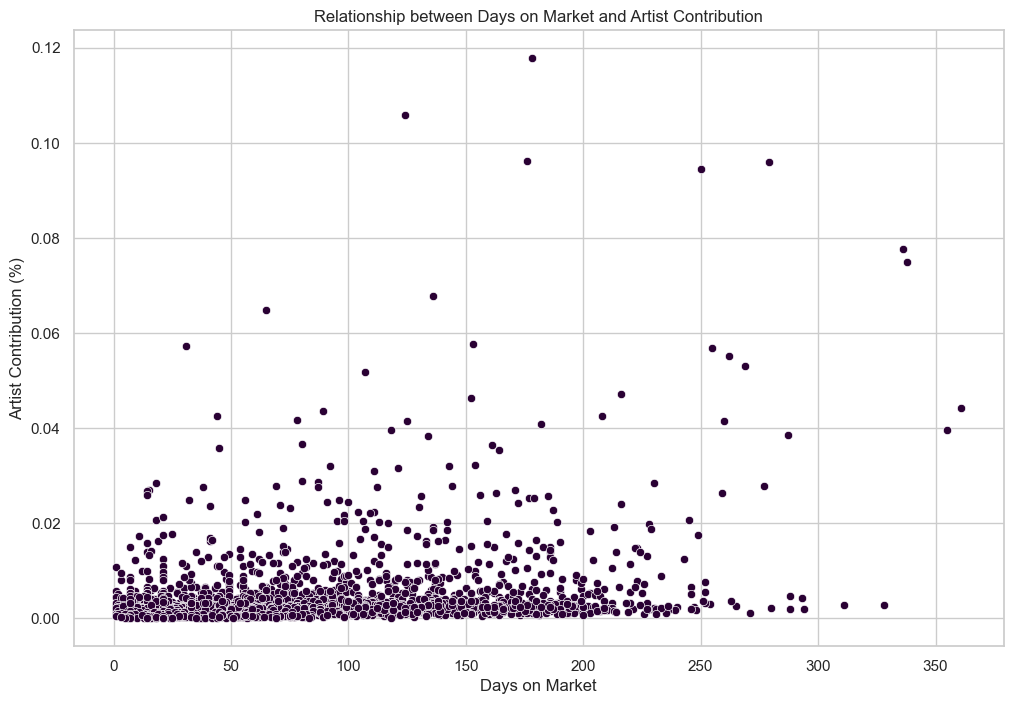

In [25]:
# Scatter plot with regression line
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Days_on_Market', y='Artist_Contribution', data=df, color='#2a0134')
plt.title('Relationship between Days on Market and Artist Contribution')
plt.xlabel('Days on Market')
plt.ylabel('Artist Contribution (%)')
plt.show()

#### Key Observations
- Some positive correlation is visible
- It would be beneficial to filter for outliers

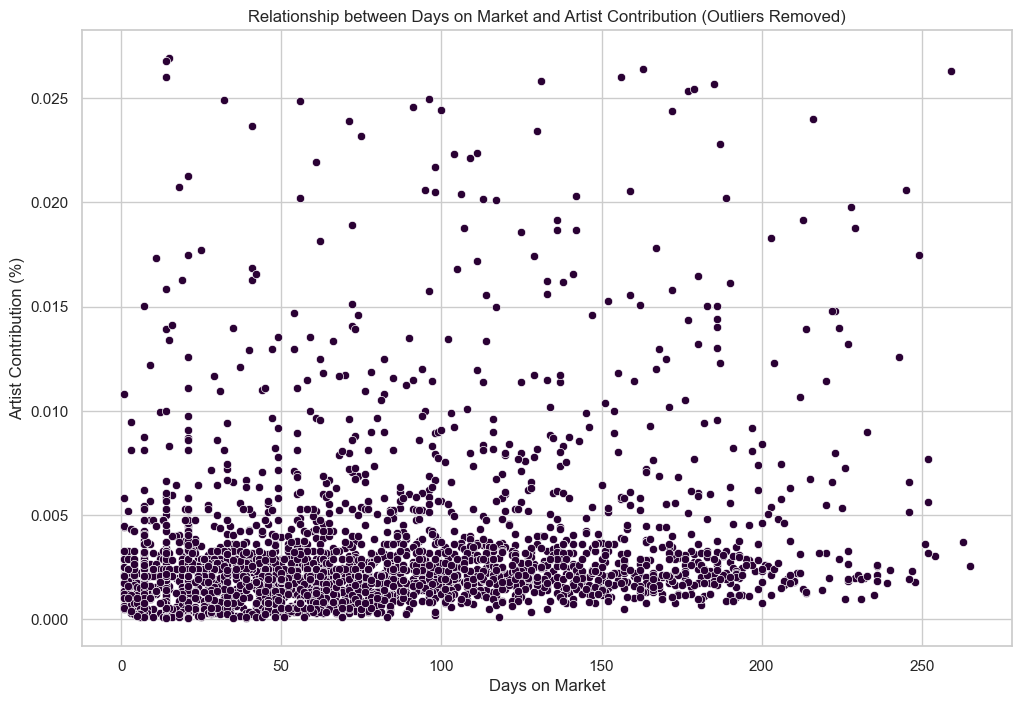

In [26]:
# Filter outliers using Z-score
filtered_df_dc = df[(np.abs(stats.zscore(df['Days_on_Market'])) < 3) & (np.abs(stats.zscore(df['Artist_Contribution'])) < 3)]

# Scatter plot with regression line for filtered data
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Days_on_Market', y='Artist_Contribution', data=filtered_df_dc, color='#2a0134')
plt.title('Relationship between Days on Market and Artist Contribution (Outliers Removed)')
plt.xlabel('Days on Market')
plt.ylabel('Artist Contribution (%)')
plt.show()

#### Key Findings
- Some correlation is noted. Further analysis could be beneficial

### 6.3 Correlation Heatmap for Multiple Features

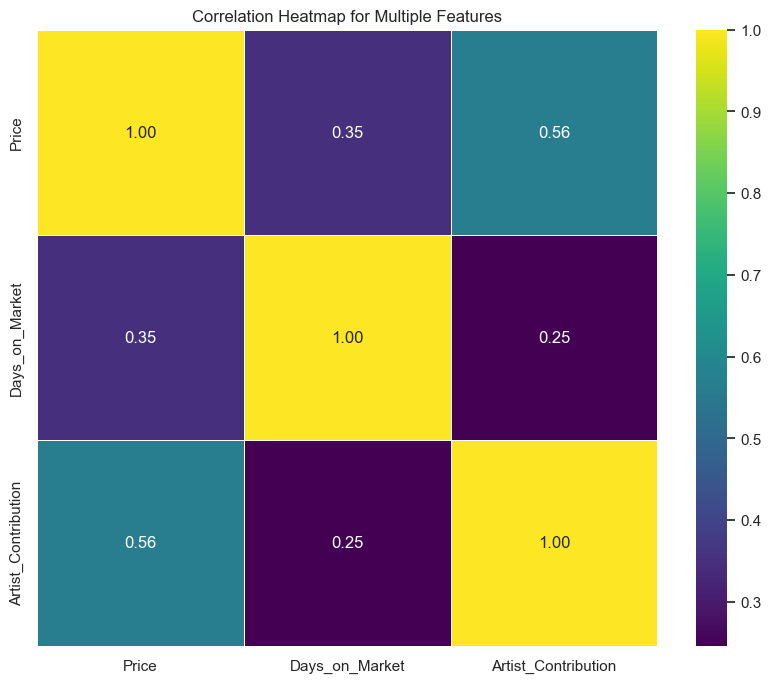

In [27]:
# Calculate correlation matrix for multiple features
features = df[['Price', 'Days_on_Market', 'Artist_Contribution']]
multiple_correlation_matrix = features.corr()

# Heatmap to visualize the correlation matrix for multiple features
plt.figure(figsize=(10, 8))
sns.heatmap(multiple_correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap for Multiple Features')
plt.show()

#### Key Observations
##### Positive Correlation with Price:
- Price has a moderately positive correlation with Artist Contribution (0.56). This suggests that, on average, higher-priced artworks tend to have a higher contribution from the artist.
There is a weak positive correlation between Price and Days on Market (0.35), indicating that higher-priced artworks might take a bit longer to sell.
##### Negative Correlation with Days on Market:
- Days on Market shows a negative correlation with both Dollars per Day (-0.23) and Price (-0.35). This implies that artworks that take longer to sell tend to have lower daily revenue and lower prices.
##### Limited Correlation with Artist Contribution and Dollars per Day:
- Artist Contribution and Dollars per Day have a very weak positive correlation (0.04), suggesting a minimal relationship between how much an artist contributes and the average revenue generated per day.
##### Business Implications:
- The positive correlation between Price and Artist Contribution could influence pricing strategies for maximizing artist returns.

## Section 7: Hypothesis Testing for Key Business Metrics
**Objective:** Test hypothesis based on correlations and, if applicable, create KPIs
### 7.1 Days on Market vs. Price

- H₀: There is no significant correlation between the price of artworks and the days they spend on the market.
- H₁: There is a significant correlation between the price of artworks and the days they spend on the market.

Reject H₀: There is a significant correlation between price and days on market.
The p-value is: 4.34132583241938e-80


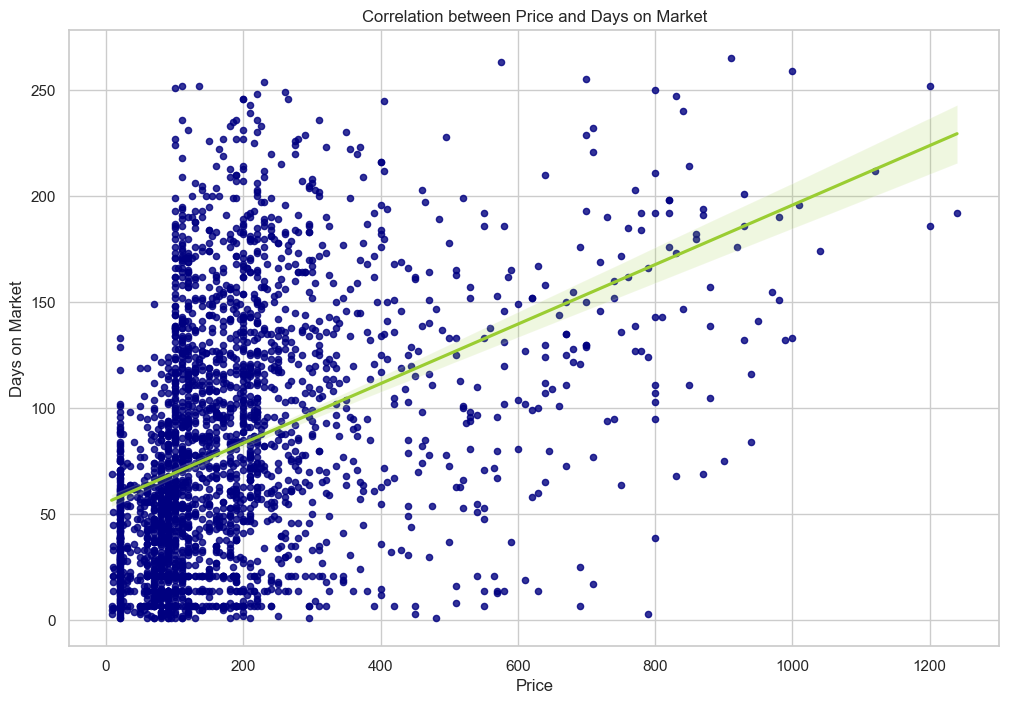

In [28]:
# Calculate Pearson correlation coefficient
corr_coefficient, p_value_days_price = stats.pearsonr(df['Price'], df['Days_on_Market'])

# Interpretation
if p_value_days_price < 0.05:
    print("Reject H₀: There is a significant correlation between price and days on market.")
else:
    print("Fail to reject H₀.")

print("The p-value is:", p_value_days_price)

# Scatter plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Days_on_Market', data=filtered_df_pd, color='navy', scatter_kws={'s': 20}, line_kws={'color': 'yellowgreen'})
plt.title('Correlation between Price and Days on Market')
plt.xlabel('Price')
plt.ylabel('Days on Market')
plt.show()

#### Create a Dollars per Day Ratio
The 'Dollars_per_Day' column can be used to assess the efficiency of selling artworks within different price ranges. This metric helps in understanding how much revenue, on average, is generated per day an artwork spends on the market. The calculation is straightforward, dividing the 'Price' by the 'Days_on_Market'.

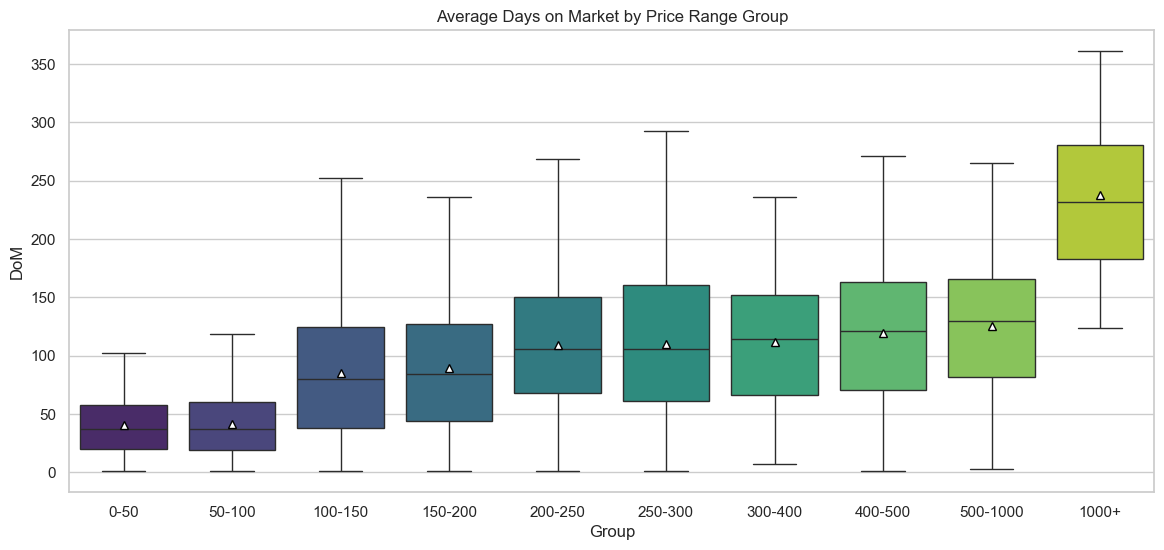

In [29]:
# Average Days on Market by Price Range Group
plt.figure(figsize=(14, 6))
avg_DoM_by_price_range = df.groupby('Price_Range')['Days_on_Market'].mean().sort_values()
sns.boxplot(x=df['Price_Range'], y=df['Days_on_Market'], order=avg_DoM_by_price_range.index, hue=df['Price_Range'], palette='viridis', showfliers=False, showmeans=True, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"})
plt.title('Average Days on Market by Price Range Group')
plt.xlabel('Group')
plt.ylabel('DoM')
plt.show()

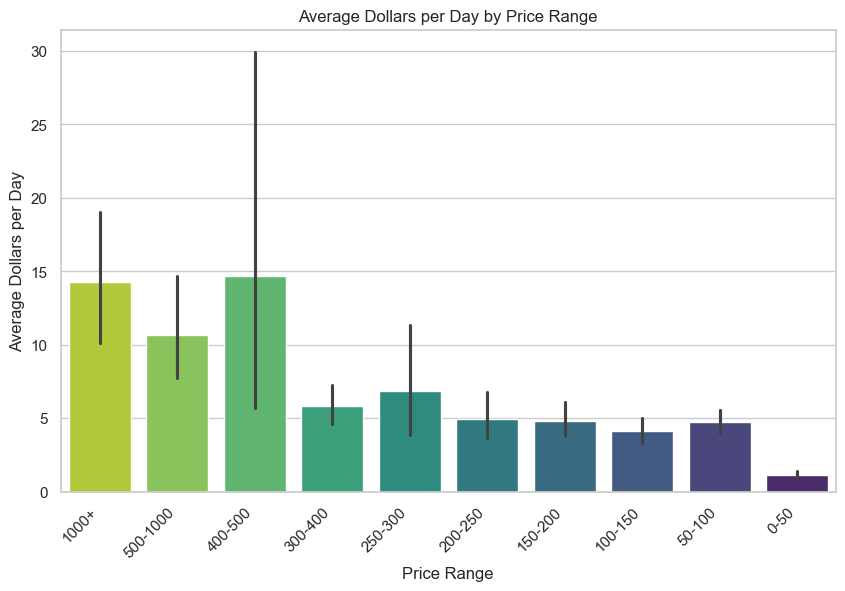

In [30]:
# Create the new column 'Dollars_per_Day'
df['Dollars_per_Day'] = df['Price'] / df['Days_on_Market']

# Group by 'Price_Range' and calculate the average of 'Dollars_per_Day' for each group
average_dollars_per_day_by_range = df.groupby('Price_Range')['Dollars_per_Day'].mean()

# Order the 'Price_Range' from smallest to largest
price_range_order = df['Price_Range'].unique()

# Set the color map to 'viridis'
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the barplot
ax = sns.barplot(x='Price_Range', y='Dollars_per_Day', data=df, order=price_range_order, hue='Price_Range', palette='viridis')

# Rotate x-axis labels by 45 degrees without triggering the warning using plt.xticks()
plt.xticks(rotation=45, ha='right')

plt.xlabel('Price Range')
plt.ylabel('Average Dollars per Day')
plt.title('Average Dollars per Day by Price Range')
plt.show()

#### Key Observations
##### Positive Correlation: 
- As the price range increases, the average dollars per day also tends to increase. This indicates that higher-priced artworks, on average, generate more revenue per day on the market as is consistent with the 0.35 correlation we saw in the heat map.
##### Potential Business Strategy: 
- The data suggests that artworks in the higher price ranges, especially those above $400, tend to yield significantly higher average profits per days spent on market.

### 7.2 Artist Contribution vs. Price

- H₀: The price of an artwork does not significantly impact the artist's contribution percentage.-  H₁: The price of an artwork significantly influences the artist's contribution percentage


Reject H₀: Price significantly influences artist contribution.
The p-value is: 3.236987367700059e-227


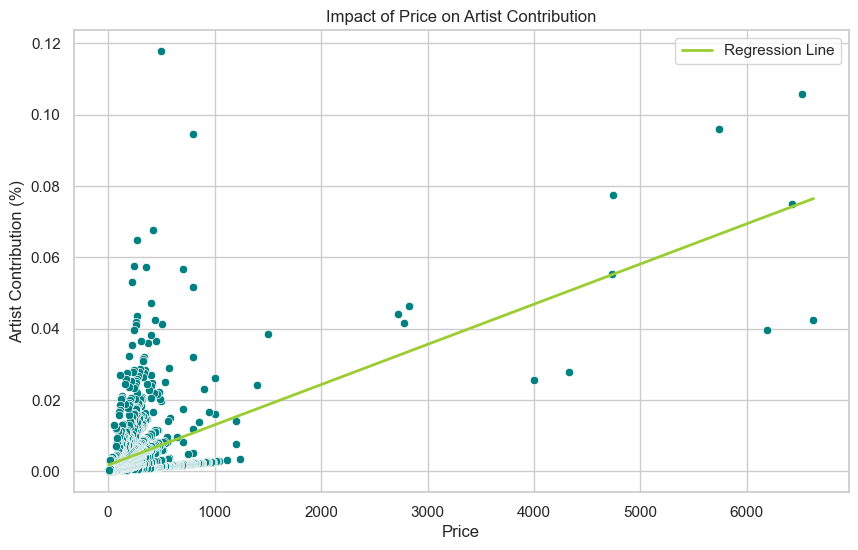

In [31]:
# Perform regression analysis
regression_model = LinearRegression().fit(df[['Price']], df['Artist_Contribution'])

# Interpretation
if not all(np.isclose(regression_model.coef_, 0)):
    print("Reject H₀: Price significantly influences artist contribution.")
else:
    print("Fail to reject H₀.")

# Calculate Pearson correlation coefficient
corr_coefficient, p_value_cont_price = stats.pearsonr(df['Price'], df['Artist_Contribution'])
print("The p-value is:", p_value_cont_price)

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Artist_Contribution', data=df, color='teal')
plt.plot(df['Price'], regression_model.predict(df[['Price']]), color='yellowgreen', linewidth=2, label='Regression Line')
plt.title('Impact of Price on Artist Contribution')
plt.xlabel('Price')
plt.ylabel('Artist Contribution (%)')
plt.legend()
plt.show()

#### Key Observations
- Rejecting the null hypothesis indicates that the price of an artwork does significantly influence the artist's contribution percentage. This suggests that, on average, there is a measurable impact of the price of an artwork on how much the artist contributes and is in line with the other correlations we've observed.

##### Pricing Strategy Optimization:
- The gallery can use this information to optimize pricing strategies. Understanding the impact of price on artist contribution allows for more informed decisions on setting prices that align with desired contribution levels.
  
##### Financial Planning for Artists:
- Artists can benefit from this insight when planning their financial expectations. Knowing that the price of their artwork has a significant influence on their contribution percentage enables better financial forecasting.

### 7.3 Artist Contribution vs. Days on Market:

- H₀: There is no significant relationship between the days an artwork spends on the market and the artist's contribution percentage.
- H₁: There is a significant relationship between the days an artwork spends on the market and the artist's contribution percentage.

Reject H₀: There is a significant relationship between days on market and artist contribution.
The p-value is: 7.503406973045262e-39


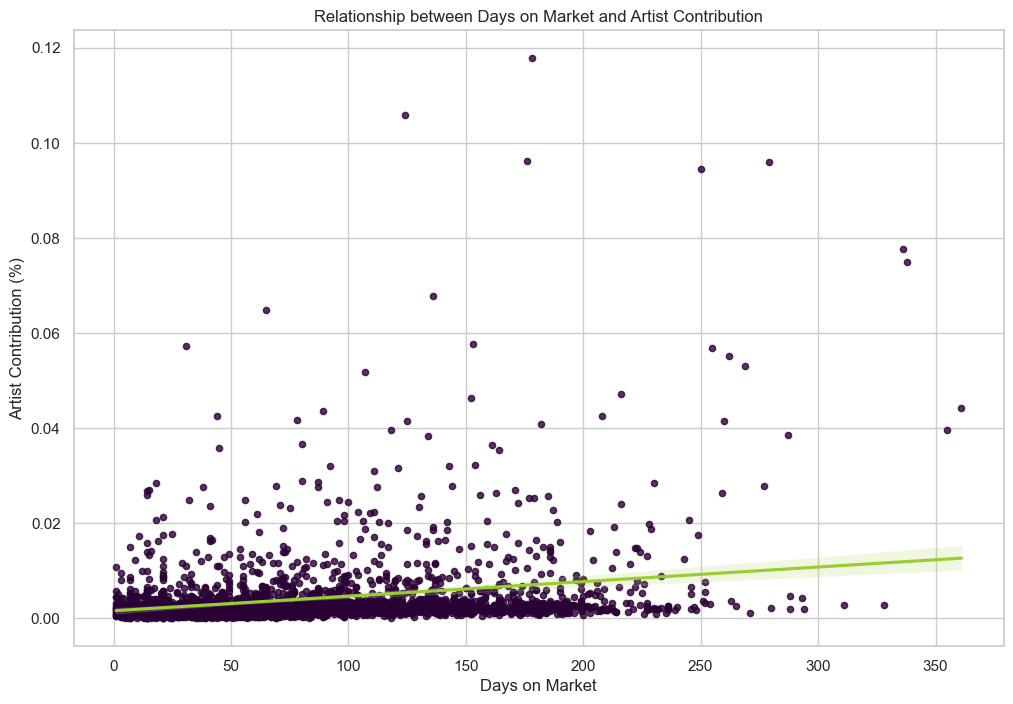

In [32]:
# Calculate correlation coefficient
corr_coefficient, p_value_days_contrib = stats.pearsonr(df['Days_on_Market'], df['Artist_Contribution'])

# Interpretation
if p_value_days_contrib < 0.05:
    print("Reject H₀: There is a significant relationship between days on market and artist contribution.")
else:
    print("Fail to reject H₀.")

print("The p-value is:", p_value_days_contrib)

# Scatter plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='Days_on_Market', y='Artist_Contribution', data=df, color='#2a0134', scatter_kws={'s': 20}, line_kws={'color': 'yellowgreen'})
plt.title('Relationship between Days on Market and Artist Contribution')
plt.xlabel('Days on Market')
plt.ylabel('Artist Contribution (%)')
plt.show()

#### Key Observations
- The rejection of the null hypothesis implies that there is a statistically significant relationship between the time an artwork spends on the market and the artist's contribution percentage. 
- Artworks that spend more or less time on the market have a notable impact on how much the artist contributes.
- Promotion efforts can be adjusted based on how long an artwork has been on the market.

In [33]:
df.to_csv('WALRUS_soldinventory_clean.csv')

## Section 8: Business Implications

### 8.1 Days on Market vs. Price

The significant correlation between the price of artworks and the days they spend on the market implies that higher-priced artworks may take longer to sell. This could influence inventory management and pricing strategies. Businesses might consider targeted marketing or promotional events for high-priced artworks to reduce their time on the market.

### 8.2 Artist Contribution vs. Price

The rejection of the null hypothesis suggests that the price of an artwork significantly influences the artist's contribution percentage. Businesses can leverage this insight to negotiate favorable terms with artists based on the pricing strategy. It also opens avenues for collaborative pricing decisions that benefit both the business and the artists.

### 8.3 Artist Contribution vs. Days on Market

The significant relationship between the days an artwork spends on the market and the artist's contribution percentage indicates that the speed of sales might impact the artist's earnings. Businesses can strategize to optimize both the pricing and marketing of artworks to maximize contributions to artists.

### 8.4 Next Steps

#### Predictive Analytics:

Building predictive models could enhance business decision-making. Predictive analytics can forecast the potential days on market for new artworks based on their characteristics. This allows for proactive inventory management and targeted marketing efforts.

#### Fine-Tuning Pricing Strategies:

Continuously monitor the correlation between price and days on market. Fine-tune pricing strategies based on market trends, competitor analysis, and customer preferences to optimize sales performance.

#### Artist Relationship Management:

Further explore the dynamics of artist contributions and their relationship with sales. Develop strategies to nurture artist relationships, ensuring mutual benefit and incentivizing artists to create high-quality, marketable artworks.

#### Seasonal Trends and Marketing:

Analyze historical data to identify seasonal trends in art sales. Adjust inventory and marketing strategies accordingly, offering promotions or themed collections during periods of increased demand.


## Conclusion

In conclusion, the analysis of the WALRUS sales dataset has provided valuable insights into the relationships between artwork price, days on market, and artist contribution. By implementing these findings, the business can optimize its operations and improve sales performance.